# SNN-CLAPP

In [1]:
import matplotlib.pyplot as plt
from utils import load_NMNIST, train, test
from model import CLAPP_SNN
import numpy as np
import torch

device = 'cpu'
epochs = 1
batch_size = 1
n_inputs = 34 * 34 * 2
n_hidden = 3 * [512]
n_outputs = 10

## Dataset
N-MNIST 


(34, 34, 2)
torch.Size([1, 6, 2, 34, 34])


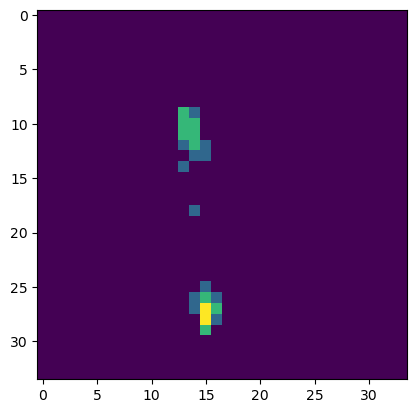

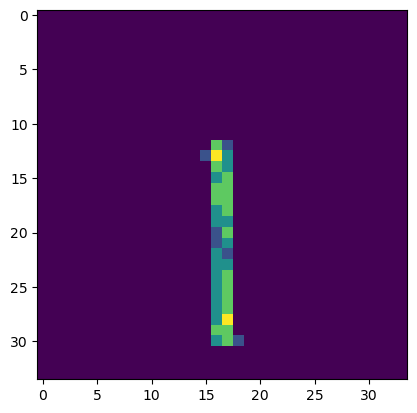

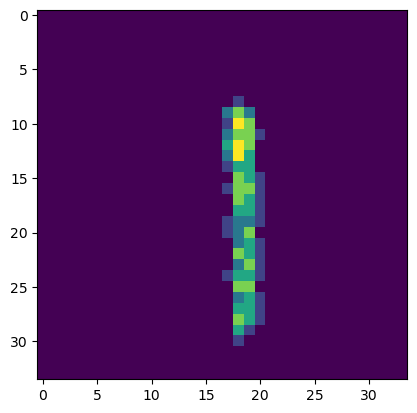

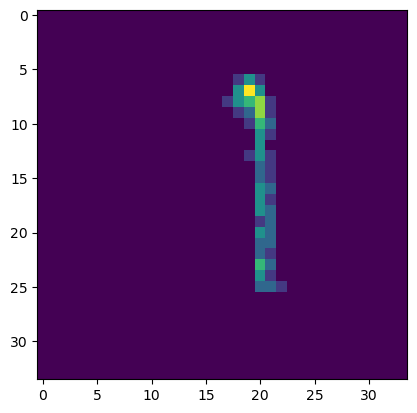

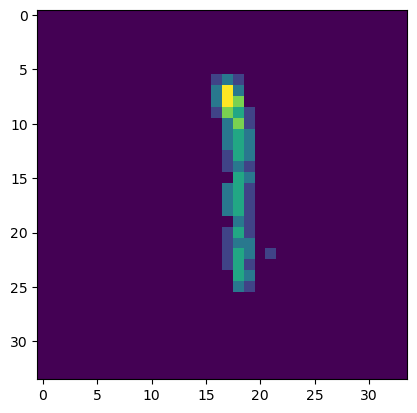

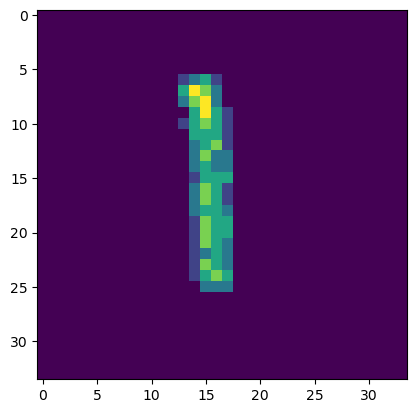

In [2]:
n_time_bins = 6
train_loader, test_loader = load_NMNIST(n_time_bins, batch_size=batch_size)

# Plot Example
frames, target = next(iter(train_loader))
print(frames.shape)
for i in range(n_time_bins):
    plt.figure()
    plt.imshow(frames[0,i,0])
frames, target = next(iter(train_loader))

## Training

In [3]:

SNN = CLAPP_SNN(n_inputs, n_hidden, n_outputs, n_time_bins).to(device)
loss_hist, mem_history, target_list = train(SNN, train_loader, epochs, device)
plt.plot(loss_hist)
plt.show()
correct, clapp_activation, target_list = test(SNN, test_loader, device)
print(correct)
print('Accuracy:', sum(correct)/10000)

AttributeError: 'CLAPP_out' object has no attribute 'num_out'

# Analyze Weights Directly

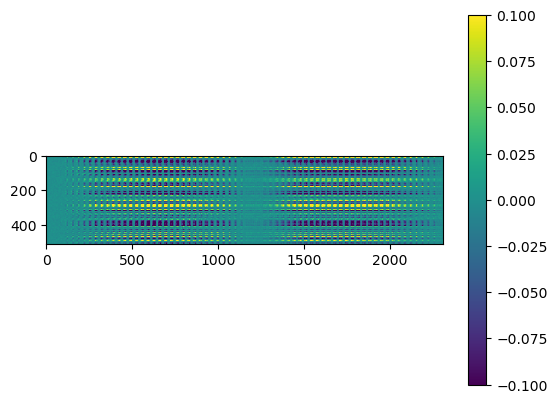

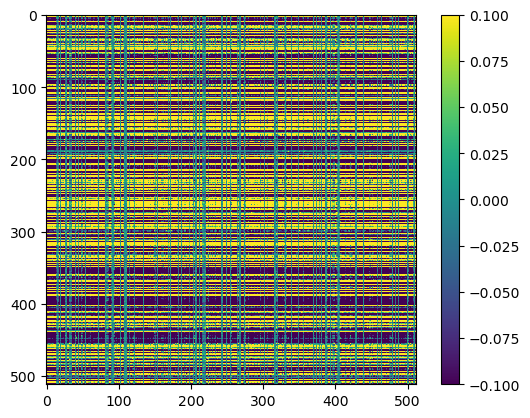

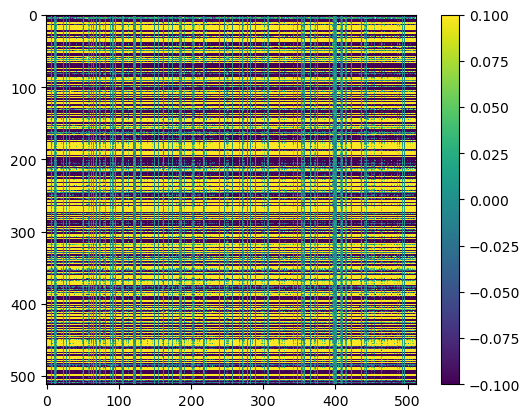

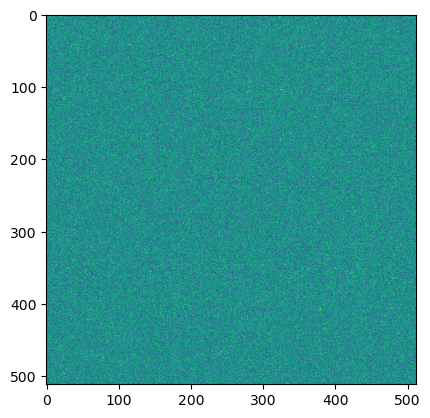

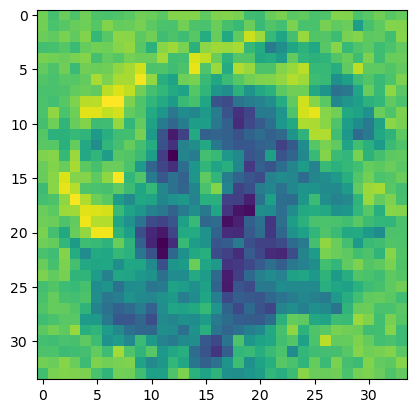

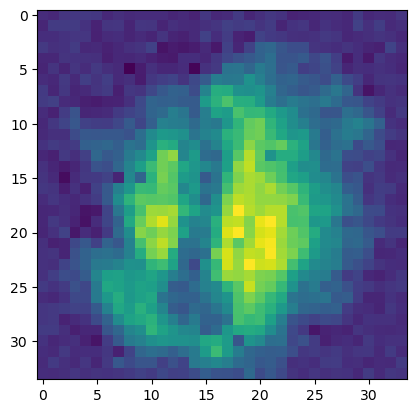

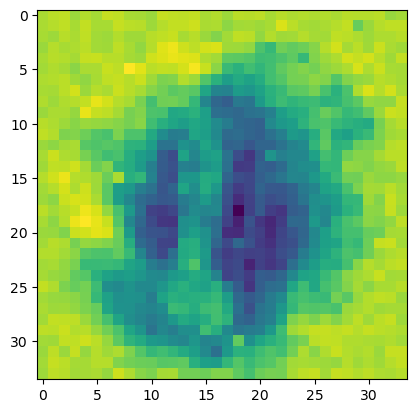

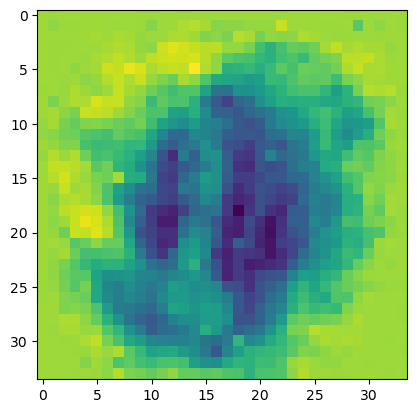

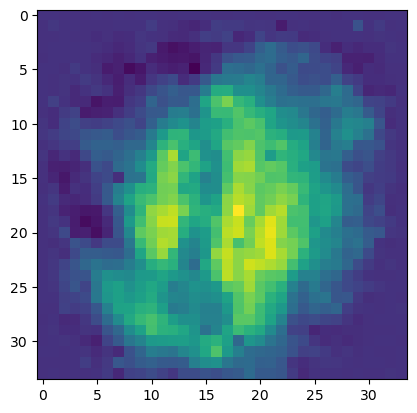

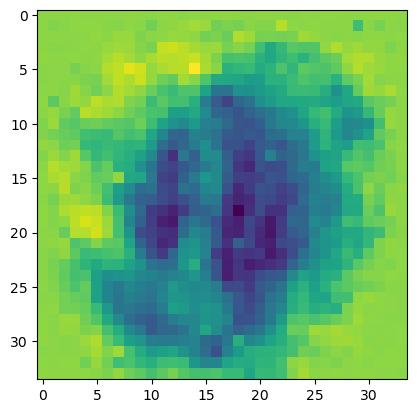

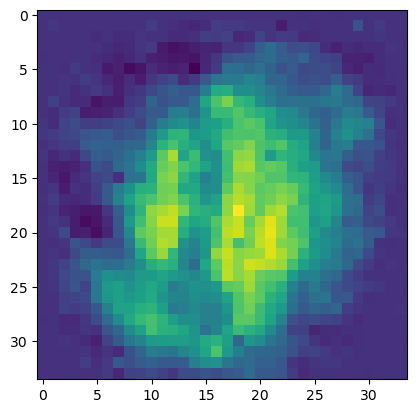

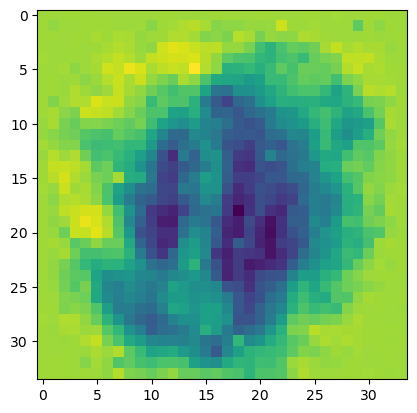

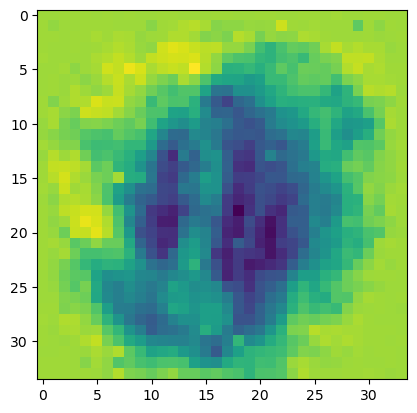

In [ ]:
layers = [SNN.clapp[0].fc.weight]
for i in range(1, len(SNN.clapp)):
    layers.append(SNN.clapp[i].fc.weight @ layers[-1])

for i in range(len(SNN.clapp)):
    plt.figure()
    plt.imshow(SNN.clapp[i].fc.weight.detach(), vmax=1e-1, vmin=-1e-1)
    plt.colorbar()
plt.figure()
plt.imshow(SNN.clapp[0].retro.weight.detach())
plt.show()
for lay in layers:
    for i in range(100, 103):
        plt.figure()
        plt.imshow(lay[i].view(2, 34, 34).detach()[0])

torch.Size([60000, 512]) torch.Size([6, 3, 512])


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(60000, 2)
(60000, 2)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(60000, 2)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


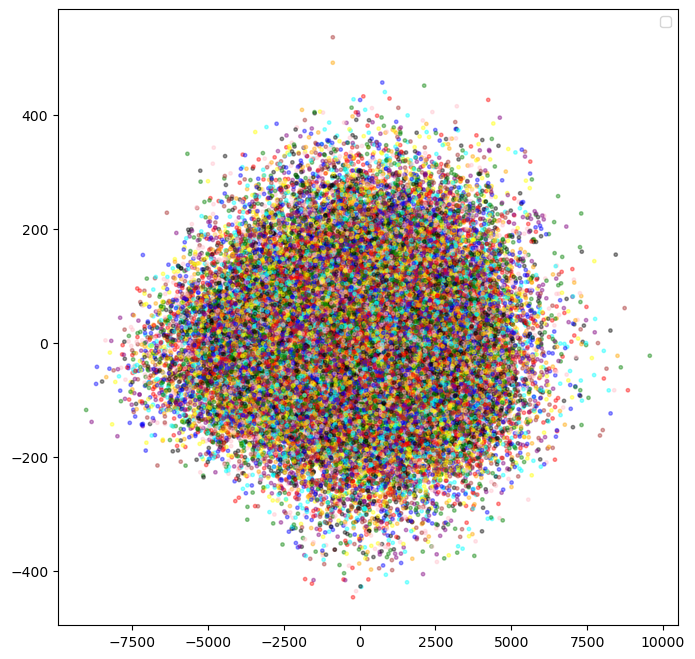

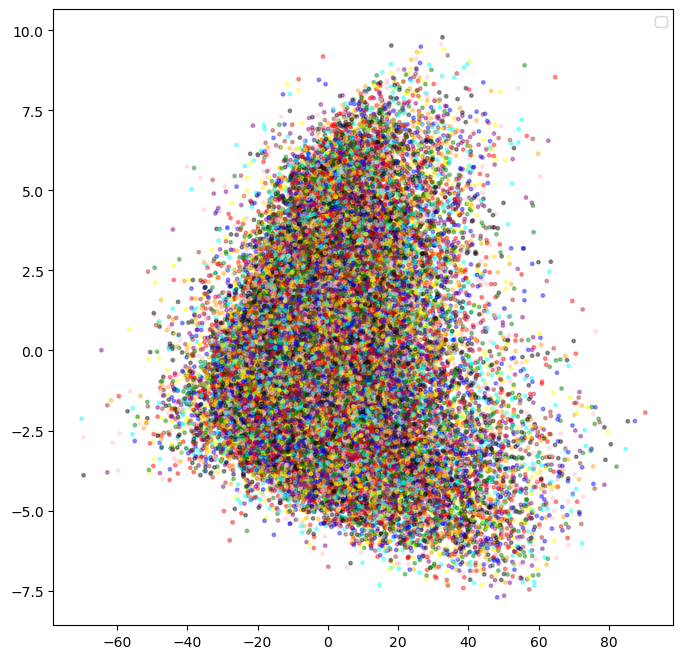

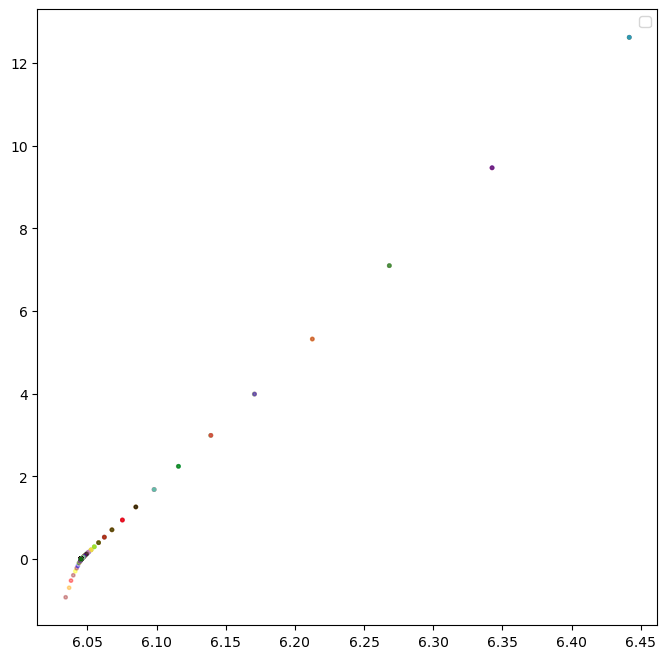

In [ ]:
hidden_activities_transformed = []
for i in range(len(n_hidden)):
    hidden_activities_transformed.append(torch.cat([h[:,i] for h in clapp_activation], 0))
print(hidden_activities_transformed[0].shape, clapp_activation[0].shape)

from sklearn.decomposition import PCA
pca = PCA(n_components=2)

color_list = ['red', 'green', 'blue', 'yellow', 'black', 'orange', 'purple', 'pink', 'brown', 'cyan']
colors = [color_list[i] for i in torch.tensor(target_list).repeat(n_time_bins)]
pca = PCA(n_components=2)
for hat in hidden_activities_transformed:
    hat_pca = pca.fit_transform(hat.detach().numpy())
    print(hat_pca.shape)
    plt.figure(figsize=(8,8))
    plt.scatter(hat_pca[:,0], hat_pca[:,1], s=6, c=colors, alpha=0.4)
    plt.legend()

# Train output Projection

In [ ]:
# Gradient calculation + weight update
optimizer = torch.optim.Adam(SNN.parameters(), lr=2e-4)

optimizer.zero_grad()
loss_val.backward()
optimizer.step()

NameError: name 'loss_val' is not defined